## CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. The classes are completely mutually exclusive. 


In [1]:
# Run some setup code for this notebook.
from __future__ import print_function

import random
import numpy as np
import matplotlib.pyplot as plt
import os

from builtins import range
from six.moves import cPickle as pickle
from imageio import imread
import platform

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# # Use this code to download the dataset for the first time
# # You will be required to install wget using pip

#!pip install wget
#!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz

x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


### Load the dataset

In [3]:
# This cell loads the training and testing dataset. Please note the variables at
# the end of the cell as you would require them to access the train/test data 
# and labels throughout the assignment
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))


def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


cifar10_dir = 'cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Visualization

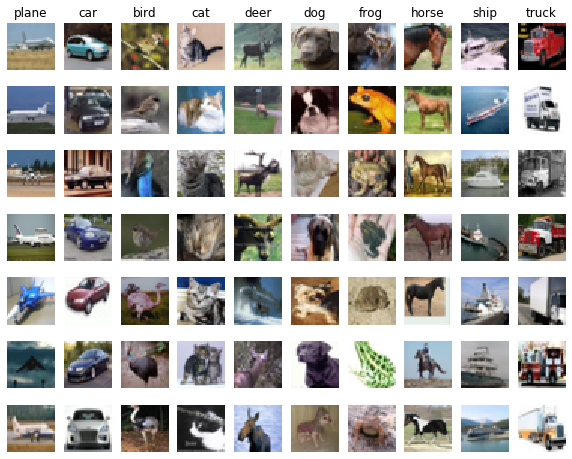

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Flattening the images

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


### Applying ML Classification Models

#### K - Nearest Neighbours

The k-Nearest Neighbors(kNN) algorithm determines the target value of a new data point or instance by comparing it with existing data points or instances that are closest to it. The target values of the k-closest instances are aggregated and taken as the target output for the new data point.

Advantages of KNN

1. No Training Period: KNN is called Lazy Learner (Instance based learning). It does not learn anything in the training period. It does not derive any discriminative function from the training data. In other words, there is no training period for it. It stores the training dataset and learns from it only at the time of making real time predictions. This makes the KNN algorithm much faster than other algorithms that require training e.g. SVM, Linear Regression etc.

2. Since the KNN algorithm requires no training before making predictions, new data can be added seamlessly which will not impact the accuracy of the algorithm.

3. KNN is very easy to implement. There are only two parameters required to implement KNN i.e. the value of K and the distance function (e.g. Euclidean or Manhattan etc.)

Disadvantages of KNN

1. Does not work well with large dataset: In large datasets, the cost of calculating the distance between the new point and each existing points is huge which degrades the performance of the algorithm.

2. Does not work well with high dimensions: The KNN algorithm doesn't work well with high dimensional data because with large number of dimensions, it becomes difficult for the algorithm to calculate the distance in each dimension.

3. Need feature scaling: We need to do feature scaling (standardization and normalization) before applying KNN algorithm to any dataset. If we don't do so, KNN may generate wrong predictions.

4. Sensitive to noisy data, missing values and outliers: KNN is sensitive to noise in the dataset. We need to manually impute missing values and remove outliers.

In [6]:
#create model
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3,metric="euclidean")
model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [7]:
#get accuracies
train_accuracy = model.score(X_train,y_train)
test_accuracy = model.score(X_test,y_test)
print(train_accuracy,test_accuracy)

0.5232 0.272


One of the challenges in a k-NN algorithm is finding the best 'k' i.e. the number of neighbors to be used in the majority vote while deciding the class. Generally, it is advisable to test the accuracy of your model for different values of k and then select the best one from them. Here, k is the hyperparameter.

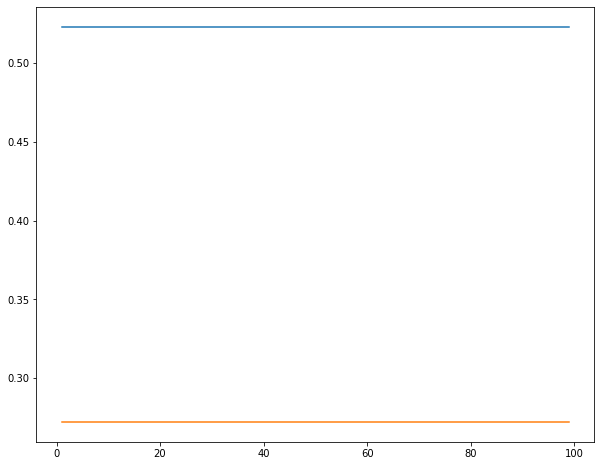

In [9]:
#k hyperparameter hypertuning
#hyperparameter vs accuracy score
train_accuracies = []
test_accuracies = []

k_vals = [i for i in range(1,100)]

for k in k_vals:
    model = KNeighborsClassifier(n_neighbors=3,metric="euclidean")
    model.fit(X_train,y_train)
    train_accuracy_k = model.score(X_train,y_train)
    test_accuracy_k = model.score(X_test,y_test)
    train_accuracies.append(train_accuracy_k)
    test_accuracies.append(test_accuracy_k)
    
plt.plot(k_vals,train_accuracies)
plt.plot(k_vals,test_accuracies)

In [8]:
y_pred = model.predict(X_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.272

In [9]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=classes))

              precision    recall  f1-score   support

       plane       0.32      0.63      0.43        57
         car       0.53      0.24      0.33        41
        bird       0.19      0.47      0.27        51
         cat       0.26      0.18      0.21        49
        deer       0.13      0.30      0.18        40
         dog       0.12      0.04      0.06        48
        frog       0.37      0.19      0.25        54
       horse       0.33      0.02      0.04        47
        ship       0.48      0.53      0.50        57
       truck       0.33      0.04      0.06        56

    accuracy                           0.27       500
   macro avg       0.31      0.26      0.23       500
weighted avg       0.31      0.27      0.24       500



#### Decision Tree

Decision Trees is a supervised learning technique which can be used for both regression and classification problems. The goal of using a Decision Tree is to create a training model that can use to predict the class or value of the target variable by learning simple decision rules inferred from training data.

In Decision Trees, for predicting a class label for a record we start from the root of the tree. We compare the values of the root attribute with the record’s attribute. On the basis of comparison, we follow the branch corresponding to that value and jump to the next node.

A decision tree is a tree-like structure in which:
1. the root node and each internal node represent a "test" on an attribute of an instance in the dataset.
2. the outcome of each test is represented by the corresponding branches.
3. the node that does not branch further is called a leaf node and represents the class labels.

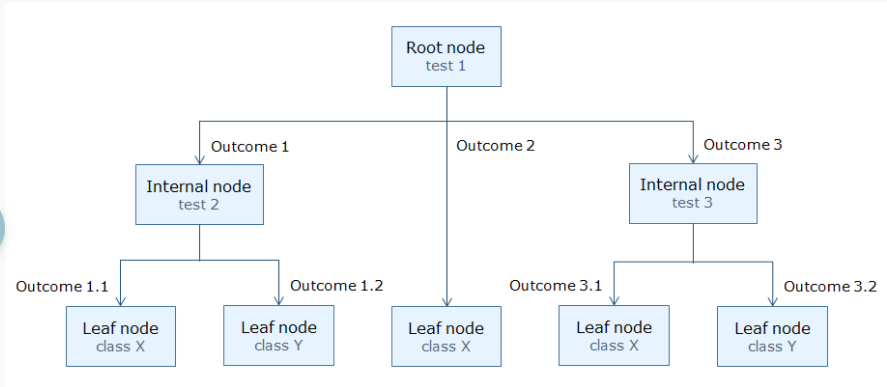

Advantages:

1. Compared to other algorithms decision trees requires less effort for data preparation during pre-processing.
2. A decision tree does not require normalization of data.
3. A decision tree does not require scaling of data as well.
4. Missing values in the data also do NOT affect the process of building a decision tree to any considerable extent.
5. A Decision tree model is very intuitive and easy to explain to technical teams as well as stakeholders.

Disadvantages:

1. A small change in the data can cause a large change in the structure of the decision tree causing instability.
2. For a Decision tree sometimes calculation can go far more complex compared to other algorithms.
3. Decision tree often involves higher time to train the model.
4. Decision tree training is relatively expensive as the complexity and time has taken are more.
5. The Decision Tree algorithm is inadequate for applying regression and predicting continuous values.

In [6]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [7]:
from sklearn.tree import export_graphviz
import graphviz
# Generating the tree
dot_data = export_graphviz(model, out_file=None,
                          class_names=classes)
                          
graph = graphviz.Source(dot_data) 
graph

In [8]:
# Getting the accuracy on train data
train_accuracy = model.score(X_train,y_train)
print("Accuracy of the model on train data = ",train_accuracy)
# Getting the accuracy on test data
test_accuracy = model.score(X_test,y_test)
print("Accuracy of the model on test data = ",test_accuracy)

Accuracy of the model on train data =  1.0
Accuracy of the model on test data =  0.198


You can observe that the training accuracy is 100% and the test accuracy is approximately 20%.

This could mean that the model is overfit to the training data and is not a good approximation of the input to output mapping.

In order to avoid this problem, certain hyperparameters of the decision tree algorithmcan be tuned.

Hyperparameters are model properties which guide the training process i.e. they cannot be learnt from the training data.

For example, the below code demonstrates creating two models with different values for the following hyper-parameters:

min_samples_split: The minimum number of instances that should be at a node before the algorithm does a further split on it.

min_impurity_decrease: The minimum percentage reduction in the impurity of a set (as measured by gini index) required to make a spli

In [12]:
# Model 1:
# Min number of samples required in a set to split = 10
# Min reduction in impurity required for split to be included in the tree = 0.005
model1 = DecisionTreeClassifier(min_samples_split=10,min_impurity_decrease=0.005)
# Fitting the model to the training data
model1.fit(X_train,y_train)
# Measuring the accuracy of the model
print("train_accuracy = ", model1.score(X_train,y_train))
print("test_accuracy = ", model1.score(X_test,y_test))

train_accuracy =  0.234
test_accuracy =  0.236


In [20]:
# Model 2:
# Min number of samples required in a set to split = 10
# Min reduction in impurity required for split to be included in the tree = 0.1
model2 = DecisionTreeClassifier(min_samples_split=10,min_impurity_decrease=0.0005)
# Fitting the model to the training data
model2.fit(X_train,y_train)
# Measuring the accuracy of the model
print("Model2 train accuracy = ", model2.score(X_train,y_train))
print("Model2 test accuracy = ", model2.score(X_test,y_test))

Model2 train accuracy =  0.7952
Model2 test accuracy =  0.204


You can observe that with different values of hyperparameters, we can get different accuracy and reduce overfitting.

In [21]:
y_pred = model.predict(X_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.198

In [22]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=classes))

              precision    recall  f1-score   support

       plane       0.20      0.23      0.21        57
         car       0.19      0.20      0.19        41
        bird       0.25      0.27      0.26        51
         cat       0.10      0.12      0.11        49
        deer       0.15      0.15      0.15        40
         dog       0.21      0.21      0.21        48
        frog       0.08      0.06      0.07        54
       horse       0.23      0.23      0.23        47
        ship       0.22      0.19      0.20        57
       truck       0.33      0.30      0.31        56

    accuracy                           0.20       500
   macro avg       0.20      0.20      0.20       500
weighted avg       0.20      0.20      0.20       500



Text(0, 0.5, 'Accuracy')

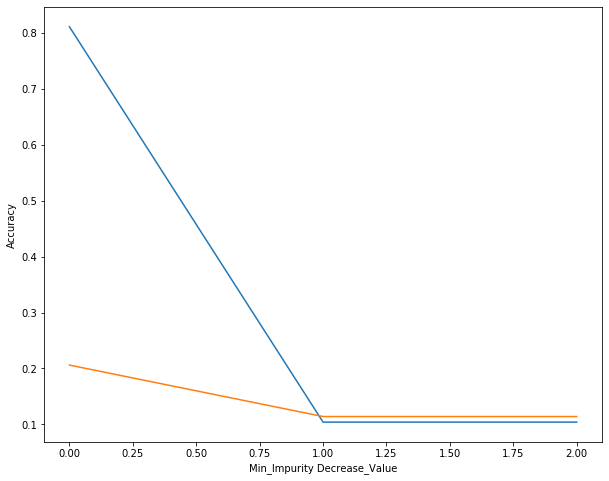

In [33]:
#hyperparameter vs accuracy score
train_accuracies = []
test_accuracies = []

min_impurity_decrease_vals = [i for i in range(0,3)]

for k in min_impurity_decrease_vals:
    model =DecisionTreeClassifier(min_samples_split=10,min_impurity_decrease=k)
    model.fit(X_train,y_train)
    train_accuracy_k = model.score(X_train,y_train)
    test_accuracy_k = model.score(X_test,y_test)
    train_accuracies.append(train_accuracy_k)
    test_accuracies.append(test_accuracy_k)
    
plt.plot(min_impurity_decrease_vals,train_accuracies)
plt.plot(min_impurity_decrease_vals,test_accuracies)
plt.xlabel("Min_Impurity Decrease_Value")
plt.ylabel("Accuracy")

#### Support Vector Machine

Support Vector Machine (SVM) is a supervised machine learning algorithm that can be used for both classification or regression challenges. However, it is mostly used in classification problems. In this SVM algorithm, we plot each data item as a point in n-dimensional space (where n is the number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiates the two classes very well.

Some of the key parameters in SVM are:
1. Gamma : defines how far the influence of single training examples reaches values leads to biased results.
2. C : Controls the cost of miscalculations
   a. Small C — makes the cost of misclassification LOW
   b. Large C — makes the cost of misclassification HIGH
3. Kernel : SVM algorithms use a set of mathematical functions that are defined as the kernel.
Types of Kernels are: Linear, RBF(Radial Basis Function), Polynomial Kernel

GridSearchCV

It is a library function that is a member of sklearn’s model_selection package. It helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters.

Pros and Cons associated with SVM

Pros:
1. It works really well with a clear margin of separation
2. It is effective in high dimensional spaces.
3. It is effective in cases where the number of dimensions is greater than the number of samples.
4. It uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

Cons:
1. It doesn’t perform well when we have large data set because the required training time is higher
2. It also doesn’t perform very well, when the data set has more noise i.e. target classes are overlapping
3. SVM doesn’t directly provide probability estimates, these are calculated using an expensive five-fold cross-validation. It is included in the related SVC method of Python scikit-learn library.

Properties of SVM

1. The number of points that lie between the hyperplane and margin are as minimal as possible.
2. In an ideal classification, the points to the right of margin on right would all belong to one class and the points to left of margin on left should all belong to a different class.
3. The distance (margin) between the support vectors and hyperplane is as high as possible.
4. The hyperplane is equi-distant to both the margins.

In [6]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)

In [7]:
model.fit(X_train,y_train)

C:\Users\sowmy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [8]:
#get accuracies
train_accuracy = model.score(X_train,y_train)
test_accuracy = model.score(X_test,y_test)
print(train_accuracy,test_accuracy)

1.0 0.356


In [10]:
y_pred = model.predict(X_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.356

In [11]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=classes))

              precision    recall  f1-score   support

       plane       0.38      0.42      0.40        57
         car       0.41      0.41      0.41        41
        bird       0.30      0.41      0.35        51
         cat       0.30      0.31      0.30        49
        deer       0.20      0.28      0.23        40
         dog       0.30      0.29      0.29        48
        frog       0.56      0.33      0.42        54
       horse       0.34      0.32      0.33        47
        ship       0.40      0.39      0.39        57
       truck       0.51      0.38      0.43        56

    accuracy                           0.36       500
   macro avg       0.37      0.35      0.36       500
weighted avg       0.38      0.36      0.36       500



#### Random Forest

Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

It technically is an ensemble method (based on the divide-and-conquer approach) of decision trees generated on a randomly split dataset. This collection of decision tree classifiers is also known as the forest. The individual decision trees are generated using an attribute selection indicator such as information gain, gain ratio, and Gini index for each attribute. Each tree depends on an independent random sample. In a classification problem, each tree votes and the most popular class is chosen as the final result. In the case of regression, the average of all the tree outputs is considered as the final result. It is simpler and more powerful compared to the other non-linear classification algorithms.

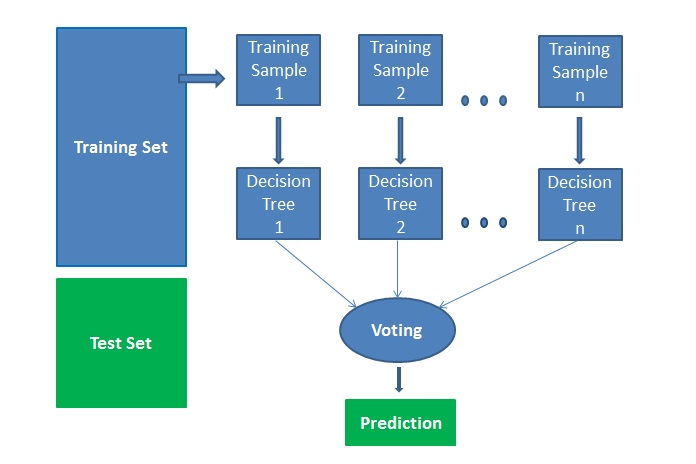

Advantages:

1. Random forests is considered as a highly accurate and robust method because of the number of decision trees participating in the process.
2. It does not suffer from the overfitting problem. The main reason is that it takes the average of all the predictions, which cancels out the biases.
3. The algorithm can be used in both classification and regression problems.
4. Random forests can also handle missing values. There are two ways to handle these: using median values to replace continuous variables, and computing the proximity-weighted average of missing values.
5. You can get the relative feature importance, which helps in selecting the most contributing features for the classifier.

Disadvantages:

1. Random forests is slow in generating predictions because it has multiple decision trees. Whenever it makes a prediction, all the trees in the forest have to make a prediction for the same given input and then perform voting on it. This whole process is time-consuming.
2. The model is difficult to interpret compared to a decision tree, where you can easily make a decision by following the path in the tree.

In [6]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
model=RandomForestClassifier(n_estimators=100)

In [7]:
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [8]:
#get accuracies
train_accuracy = model.score(X_train,y_train)
test_accuracy = model.score(X_test,y_test)
print(train_accuracy,test_accuracy)

1.0 0.37


In [9]:
y_pred = model.predict(X_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.37

In [16]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=classes))

              precision    recall  f1-score   support

       plane       0.36      0.37      0.36        57
         car       0.50      0.59      0.54        41
        bird       0.30      0.31      0.30        51
         cat       0.21      0.12      0.16        49
        deer       0.21      0.23      0.22        40
         dog       0.23      0.21      0.22        48
        frog       0.48      0.57      0.53        54
       horse       0.19      0.11      0.14        47
        ship       0.43      0.56      0.49        57
       truck       0.52      0.55      0.53        56

    accuracy                           0.37       500
   macro avg       0.34      0.36      0.35       500
weighted avg       0.35      0.37      0.36       500



#### Naive Bayes

Naive Bayes is a statistical classification technique based on Bayes Theorem. It is one of the simplest supervised learning algorithms. Naive Bayes classifier is the fast, accurate and reliable algorithm. Naive Bayes classifiers have high accuracy and speed on large datasets.

Naive Bayes classifier assumes that the effect of a particular feature in a class is independent of other features. 
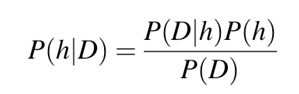
P(h): the probability of hypothesis h being true (regardless of the data). This is known as the prior probability of h.

P(D): the probability of the data (regardless of the hypothesis). This is known as the prior probability.

P(h|D): the probability of hypothesis h given the data D. This is known as posterior probability.

P(D|h): the probability of data d given that the hypothesis h was true. This is known as posterior probability.

How the classifier works?

1. Calculate the prior probability for given class labels
2. Calculate conditional probability with each attribute for each class
3. Multiply same class conditional probability.
4. Multiply prior probability with Step 3 probability.
5. See which class has a higher probability, given the input belongs to the higher probability class.

Advantages:

1. It is not only a simple approach but also a fast and accurate method for prediction.
2. Naive Bayes has very low computation cost.
3. It can efficiently work on a large dataset.
4. It performs well in case of discrete response variable compared to the continuous variable.
5. It can be used with multiple class prediction problems.
6. It also performs well in the case of text analytics problems.
7. When the assumption of independence holds, a Naive Bayes classifier performs better compared to other models like logistic regression.

Disadvantages:

1. The assumption of independent features. In practice, it is almost impossible that model will get a set of predictors which are entirely independent.
2. If there is no training tuple of a particular class, this causes zero posterior probability. In this case, the model is unable to make predictions. This problem is known as Zero Probability/Frequency Problem.

In [19]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [21]:
#get accuracies
train_accuracy = gnb.score(X_train,y_train)
test_accuracy = gnb.score(X_test,y_test)
print(train_accuracy,test_accuracy)

0.3032 0.29


In [22]:
y_pred = gnb.predict(X_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.29

In [23]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=classes))

              precision    recall  f1-score   support

       plane       0.28      0.40      0.33        57
         car       0.36      0.20      0.25        41
        bird       0.21      0.12      0.15        51
         cat       0.08      0.02      0.03        49
        deer       0.17      0.33      0.23        40
         dog       0.30      0.25      0.27        48
        frog       0.31      0.48      0.38        54
       horse       0.23      0.06      0.10        47
        ship       0.37      0.53      0.43        57
       truck       0.37      0.41      0.39        56

    accuracy                           0.29       500
   macro avg       0.27      0.28      0.26       500
weighted avg       0.27      0.29      0.26       500



In [27]:
df = pd.DataFrame(columns = ['Model','Train_Accuracy','Test_Accuracy'])
df['Model'] = ['KNN','Decision Tree','SVM','Random Forest','Naive Bayes']
df['Train_Accuracy'] = [0.5232, 0.7952, 1.0, 1.0, 0.3032]
df['Test_Accuracy'] = [0.272, 0.204, 0.356, 0.37, 0.29]
df

Model  Train_Accuracy  Test_Accuracy
0            KNN          0.5232          0.272
1  Decision Tree          0.7952          0.204
2            SVM          1.0000          0.356
3  Random Forest          1.0000          0.370
4    Naive Bayes          0.3032          0.290

From the above table, we can say that Random Forest Classifier gave more accuracy than the other classifiers.